In [2]:
from scipy.io.wavfile import read
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal, stats
import pytest
import math
import ipytest
import cProfile
ipytest.config(rewrite_asserts=True, magics=True)
__filename__ = "XC"

/Users/kitty/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
def stereo_to_mono(audio):
    return audio.sum(axis=1) / 2

In [4]:
frq, raw_sample = read("oblivion.wav")
original = stereo_to_mono(raw_sample)

In [5]:
frq, raw_sample = read("oblivion.cut.wav")
sample = stereo_to_mono(raw_sample)
# sample = stats.zscore(np.array(sample[1], dtype=float))


In [6]:
noise = np.random.normal(0, 1, sample.shape)
len(noise)

959488

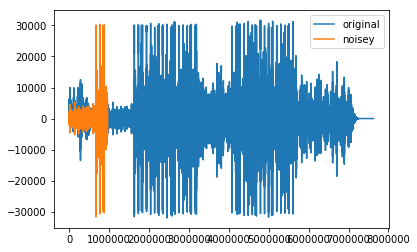

In [7]:
original_l, = plt.plot(original, label="original")
sample_l, = plt.plot(sample + noise, label="noisey sample")
plt.legend([original_l, sample_l], ["original", "noisey"])
plt.show()

In [8]:
from cmath import *
def fft(x):
        N=len(x)
        if N==1: return x
 
        even=fft([x[k] for k in range(0,N,2)])
        odd= fft([x[k] for k in range(1,N,2)])
 
        M=N/2
        l=[ even[k] + exp(-2j*pi*k/N)*odd[k] for k in range(M) ]
        r=[ even[k] - exp(-2j*pi*k/N)*odd[k] for k in range(M) ]
 
        return l+r

In [18]:
def low_pass(data, cutoff_frq, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass', output='ba')
    y = signal.filtfilt(b, a, data)
    return y
    

In [21]:
def filter_and_downsample(data):
    # low_pass preapplied
    return signal.decimate(data, 4, n=4)
filtered_data = filter_and_downsample(original)

/Users/kitty/miniconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/kitty/miniconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


In [9]:
def create_window(frq, bin_num, total_width, seconds=0.1):
    bin_size = int(frq * seconds)
    frame = np.hanning(bin_size)
    left_pad = np.zeros(bin_num * bin_size)
    right_pad = np.zeros(total_width - ((bin_num + 1) * bin_size))
    window = np.concatenate((left_pad, frame, right_pad), axis=0)
    return window

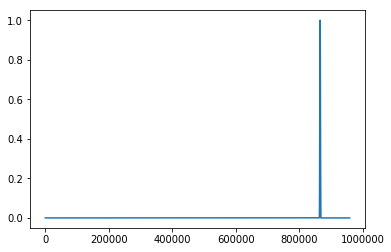

In [10]:
def test_window():
    w = create_window(48000, 180, 959488)
    assert len(w) == 959488
    assert max(w) == pytest.approx(1.0, 0.0001)
    plt.plot(w)
    plt.show()
test_window()

In [11]:
def apply_window(data, frq, bin_num):
    window = create_window(frq, bin_num, len(data))
    return data * window

In [12]:
def zero_pad(records):
    x = len(records)
    zeroes = pow(2, math.ceil(math.log(x) / math.log(2))) - x
    return np.concatenate((records, [0] * zeroes))

In [13]:
def test_zero_pad():
    records = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    ans = zero_pad(records)
    assert len(ans) == 16
test_zero_pad()

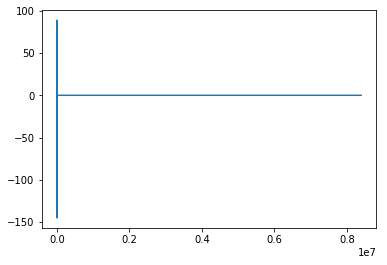

In [14]:
result = zero_pad(apply_window(original, frq, 0))
plt.plot(result)
plt.show()

In [15]:
def create_frequencies():
    seconds = 0.1
    bin_size = int(frq * seconds)
    num_bins = len(original) // bin_size
    results = []
    for bin_num in range(12): # num_bins
        values = apply_window(original, frq, bin_num)
        padded_values = zero_pad(values)
        F = np.fft.fft(padded_values)
        results.append(F)
        print(bin_num)
    return results

In [16]:
cProfile.run('create_frequencies()')

0
1
2
3
4
5
6
7
8
9
10
11
         820 function calls in 9.788 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       12    0.307    0.026    0.511    0.043 <ipython-input-11-921091b4ea2c>:1(apply_window)
       12    0.032    0.003    0.673    0.056 <ipython-input-12-051dcd2c3f8d>:1(zero_pad)
        1    0.231    0.231    9.663    9.663 <ipython-input-15-5c889a6089be>:1(create_frequencies)
       12    0.000    0.000    0.204    0.017 <ipython-input-9-b1aea92fb137>:1(create_window)
        1    0.125    0.125    9.788    9.788 <string>:1(<module>)
       12    0.000    0.000    8.246    0.687 fftpack.py:102(fft)
       12    0.000    0.000    7.926    0.661 fftpack.py:47(_raw_fft)
       12    0.000    0.000    0.000    0.000 fftpack.py:95(_unitary)
       12    0.007    0.001    0.007    0.001 function_base.py:2617(hanning)
       12    0.000    0.000    0.000    0.000 helper.py:251(put_twiddle_factors)
       12    0.00

In [22]:
# Frequency went from 44.1kHz to 11.025kHz
filtered_data.shape

(1906808,)

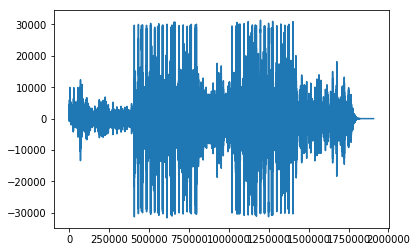

In [24]:
plt.plot(filtered_data)
plt.show()